# Validating Bigmali At Scale

We have generated the bigmali inference with synthetic datasets with masses from the Millennium Simulation ('orig' ndarray) and from the prior ('prior' ndarray). In this notebook we analyze these inferences.

Contents:
- [Original Masses from Millennium Simulation](#Original-Masses-from-Millennium-Simulation)
- [Masses Drawn From Prior](#Masses-Drawn-From-Prior)
- [Highest Weight Hyperpoint](#Highest-Weight-Hyperpoint)
- [Loglikelihood of Hyperseed](#Loglikelihood-of-Hyperseed)
- [Analyzing Weights In Each Hyperparameter Variable](#Analyzing-Weights-In-Each-Hyperparameter-Variable)
- [Discussion](#Discussion)

In [2]:
%matplotlib inline

import corner
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import rc
from bigmali.hyperparameter import get
from scipy.stats import lognorm
rc('text', usetex=True)

In [3]:
orig = np.loadtxt('bigmaliorig.out', delimiter=' ')
prior = np.loadtxt('bigmaliprior.out', delimiter=' ')
truths = get()
truths.remove(235000000000000.0)

### Original Masses from Millennium Simulation

Note that the weights in these corner plots are relative log-likelihood weights, as opposed to likelihood weights. 

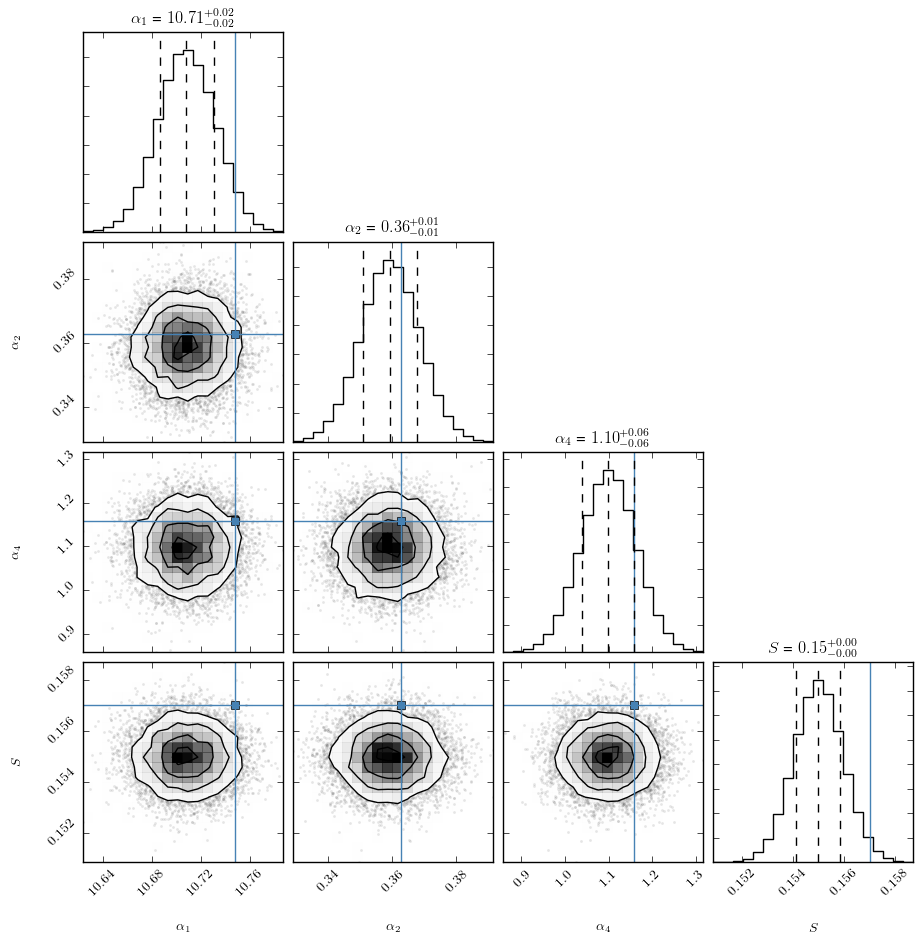

In [5]:
corner.corner(orig[:,:4], 
                       labels=[r'$\alpha_1$',r'$\alpha_2$',r'$\alpha_4$',r'$S$'],
                       weights=(orig[:,4] - orig[:,4].min()) / abs(orig[:,4].min() - orig[:,4].max()),
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True,
                       truths=truths,
                       smooth1d=True
             );

### Masses Drawn From Prior

Again, note that the weights in these corner plots are relative log-likelihood weights, as opposed to likelihood weights. 

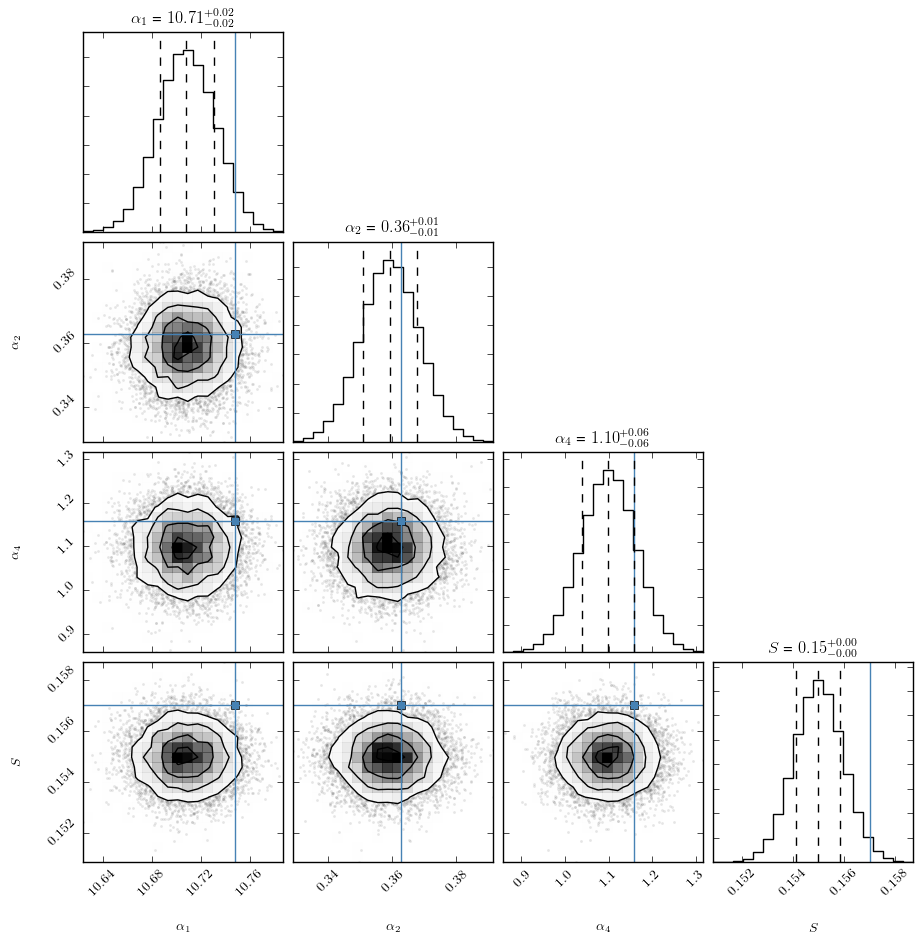

In [83]:
corner.corner(prior[:,:4], 
                       labels=[r'$\alpha_1$',r'$\alpha_2$',r'$\alpha_4$',r'$S$'],
                       weights=(prior[:,4] - prior[:,4].min()) / abs(prior[:,4].min() - prior[:,4].max()),
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True,
                       truths=truths,
                       smooth1d=True
             );

### Highest Weight Hyperpoint

Again, it is not close to true hyper-point.

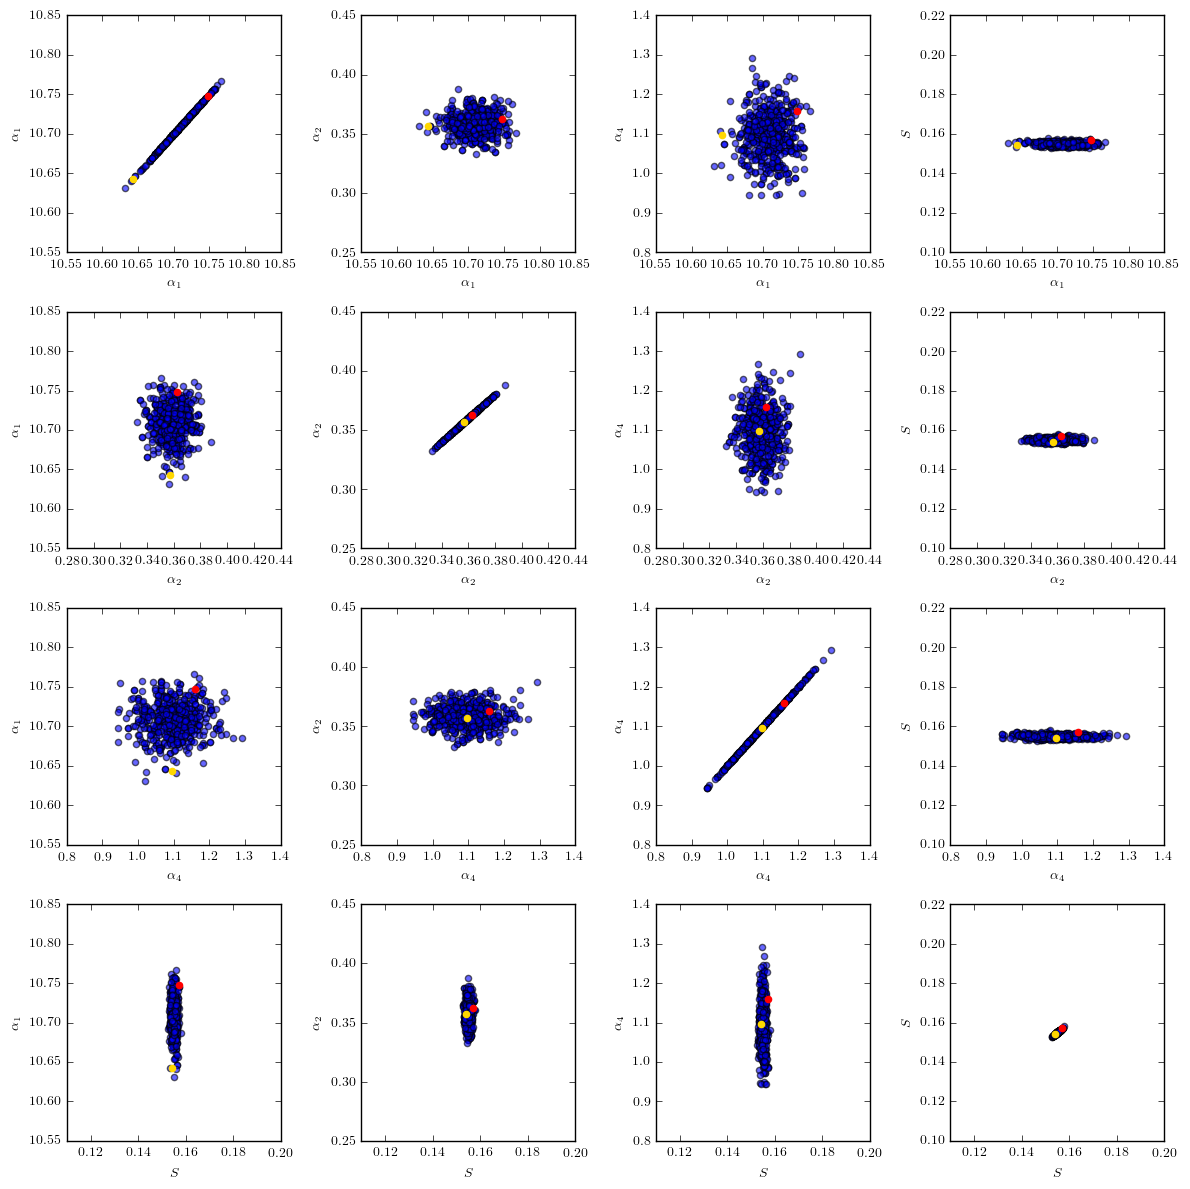

In [82]:
ma1, ma2, ma4, maS, l = prior[prior[:,4].argmax()]
best = [ma1, ma2, ma4, maS]
labels = [r'$\alpha_1$', r'$\alpha_2$', r'$\alpha_4$', r'$S$']
for i in xrange(4):
    for j in xrange(4):
        plt.subplot(4,4,i*4+j+1)
        plt.scatter(prior[:500,i], prior[:500,j], alpha=.6)
        plt.scatter(best[i], best[j], color='gold')
        plt.scatter(truths[i], truths[j], color='red')
        plt.xlabel(labels[i])
        plt.ylabel(labels[j])
plt.gcf().set_size_inches((12,12))
plt.tight_layout()

**Failure Mode 1:** The posterior is not accurate, precise, or meaningful.

### Loglikelihood of Hyperseed 
The point with highest likelihood does not appear to be close to the hyper-seeds (fixed hyper-parameters that generated the mock dataset). Next we compute the likelihood of the hyper-seed. We see that its log-likelihood does not fall to the right of the distribution, as we would hope. 

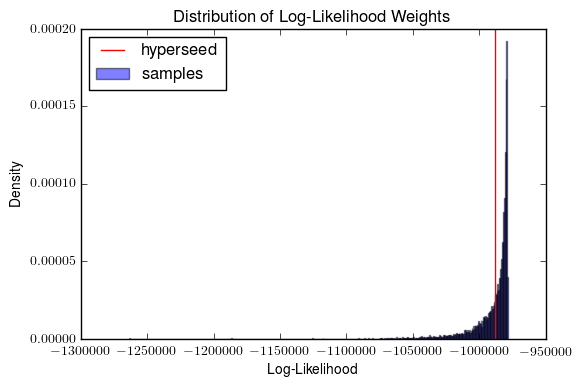

In [14]:
plt.title('Distribution of Log-Likelihood Weights')
plt.xlabel('Log-Likelihood')
plt.ylabel('Density')
plt.hist(prior[:,4],bins=500, normed=True, label='samples', alpha=0.5)
plt.gca().axvline(-987878.65344367269, label='hyperseed', color='r') # the likelihood of true hyper-point
plt.legend(loc=2);

Zooming in on the far right of this distribution ...

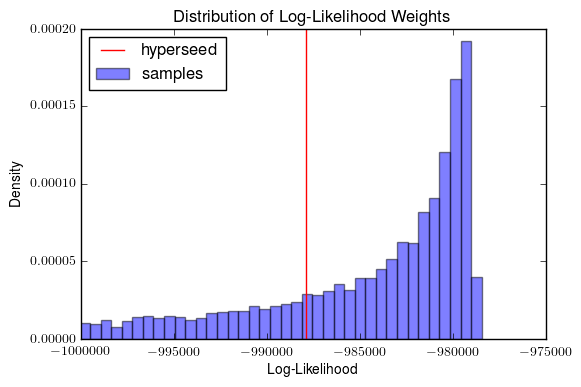

In [13]:
plt.title('Distribution of Log-Likelihood Weights')
plt.xlabel('Log-Likelihood')
plt.ylabel('Density')
plt.hist(prior[:,4],bins=500, normed=True, label='samples', alpha=0.5)
plt.gca().axvline(-987878.65344367269, label='hyperseed', color='r') # the likelihood of true hyper-point
plt.xlim([-1000000, -975000])
plt.legend(loc=2);

**Failure Mode 2:** The weight discrepencies are enormous and hence we end up with one sample dominating the inference.

### Analyzing Weights In Each Hyperparameter Variable

Next we break up the inference samples into three equally sized buckets (low, medium, high) based on their weights. Then we plot histograms of these buckets for each hyper-parameter. Ideally we would see the good bucket adjacent to the hyper-seed and the bad bucket furthest away. This is not what we observe. We see limited difference between buckets. 

It also is worth recalling the Mass-Luminosity relationship is:

\begin{align*}
P(\overline{L}|\overline{M},\alpha,S,\overline{z}) &= \frac{1}{\overline{L}S\sqrt{2\pi}}\exp\left(-\frac{(\ln \overline{L} - \ln \overline{\mu_L})^2}{2S^{2}}\right)\\
\mu_L &= \exp(\alpha_1) \cdot \left(\frac{M}{\alpha_3}\right)^{\alpha_2} \cdot (1+z)^{\alpha_4}\\
\end{align*}

In [17]:
low = prior[np.where(prior[:,4] <= np.percentile(prior[:,4], 33))]
medium = prior[np.where((np.percentile(prior[:,4], 33) < prior[:,4]) & (prior[:,4] <= np.percentile(prior[:,4], 66)))]
high = prior[np.where(np.percentile(prior[:,4], 66) < prior[:,4])]

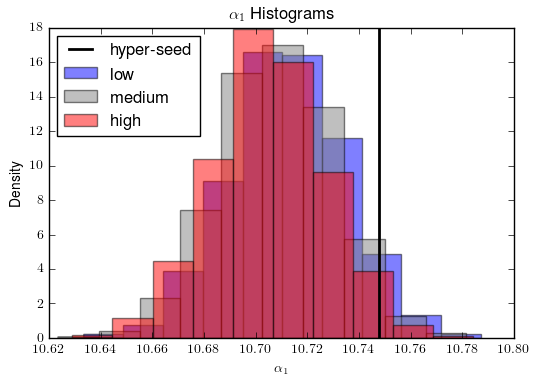

In [33]:
plt.title(r'$\alpha_1$ Histograms')
plt.hist(low[:,0], color='blue', alpha=0.5, normed=True, label='low')
plt.hist(medium[:,0], color='grey', alpha=0.5, normed=True, label='medium')
plt.hist(high[:,0], color='red', alpha=0.5, normed=True, label='high')
plt.gca().axvline(10.747809151611289, color='k', linewidth=2, label='hyper-seed')
plt.legend(loc=2)
plt.xlabel(r'$\alpha_1$')
plt.ylabel('Density');

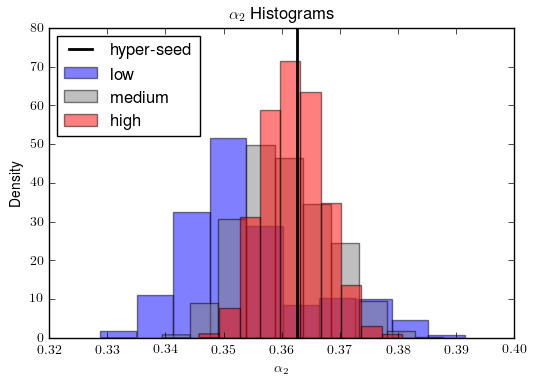

In [32]:
plt.title(r'$\alpha_2$ Histograms')
plt.hist(low[:,1], color='blue', alpha=0.5, normed=True, label='low')
plt.hist(medium[:,1], color='grey', alpha=0.5, normed=True, label='medium')
plt.hist(high[:,1], color='red', alpha=0.5, normed=True, label='high')
plt.gca().axvline(0.36260141487530501, color='k', linewidth=2, label='hyper-seed')
plt.legend(loc=2)
plt.xlabel(r'$\alpha_2$')
plt.ylabel('Density');

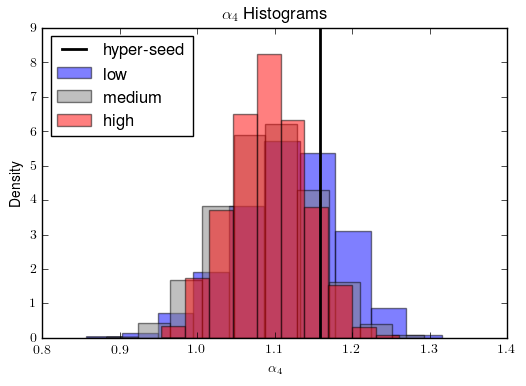

In [27]:
plt.title(r'$\alpha_4$ Histograms')
plt.hist(low[:,2], color='blue', alpha=0.5, normed=True, label='low')
plt.hist(medium[:,2], color='grey', alpha=0.5, normed=True, label='medium')
plt.hist(high[:,2], color='red', alpha=0.5, normed=True, label='high')
plt.gca().axvline(1.1587242790463443, color='k', linewidth=2, label='hyper-seed')
plt.legend(loc=2)
plt.xlabel(r'$\alpha_4$')
plt.ylabel('Density');

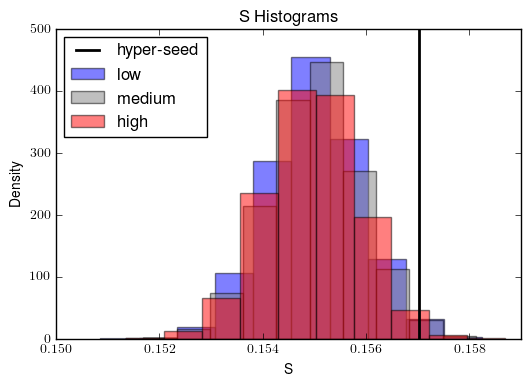

In [34]:
plt.title('S Histograms')
plt.hist(low[:,3], color='blue', alpha=0.5, normed=True, label='low')
plt.hist(medium[:,3], color='grey', alpha=0.5, normed=True, label='medium')
plt.hist(high[:,3], color='red', alpha=0.5, normed=True, label='high')
plt.gca().axvline(0.1570168038792813, color='k', linewidth=2, label='hyper-seed')
plt.legend(loc=2)
plt.xlabel('S')
plt.ylabel('Density');

At least drawing masses from the prior has higher mean log-likelihood than from using the masses from the Millennium Simulation.

In [123]:
print orig[:,4].mean()
print prior[:,4].mean()

-990516.681042
-990359.213542


# Discussion

The primary conclusion from this notebook is that the differences between the masses from the Millennium Simulation and from our prior are not responsible for either of the two failure modes:
- **Failure Mode 1:** The posterior is not accurate, precise, or meaningful.
- **Failure Mode 2:** The weight discrepencies are enormous and hence we end up with one sample dominating the inference.

Let's reiterate what we do know:
    - Our importance sampling with 100 samples gets to within ~10% accuracy on each halo's likelihood.
    - The precision seems to be independent of the halo and where that halo falls in the larger distribution.
    - We have scaled this up to ~10,000 simple monte carlo hyper-samples with ~115,000 halos in the field of view.
    
However, we have not been able to demonstrate that this pipeline can produce meaningful posteriors. In order to better understand the driving forces behind this result, we will further simplify the model/problem so that we may be able to isolate issues. Next we will see if we fix the $\alpha$ hyper-parameters in our inference, if we are able to recover a meaningful posterior on $S$.

Next notebook: [Validating Simpler Model](ValidatingSimplerModel_20160626.ipynb)